In [1]:
import pandas as pd
import sys
import os
import numpy as np
import pickle
from itertools import combinations
from joblib import Parallel, delayed
from numpy import random
import hashlib
import os
import sys
import pandas as pd
import numpy as np
import sklearn
import glob
import pickle
import random
from joblib import Parallel, delayed
import yaml
import math
from collections import Counter
sys.path.append('.')
sys.path.append('./..')

try:
    import clean_up_test_data
except:
    from . import clean_up_test_data

In [2]:
    
CONFIG_FILE = 'config_preprocessor_v02.yaml'
id_col = 'PanjivaRecordID'
ns_id_col = 'NegSampleID'
term_2_col = 'term_2'
term_4_col = 'term_4'
num_neg_samples_ape = None
use_cols = None
freq_bound = None
column_value_filters = None
num_neg_samples = None
save_dir = None
cleaned_csv_subdir = None


def set_up_config():
    global CONFIG_FILE
    global use_cols
    global freq_bound
    global num_neg_samples_ape
    global DIR
    global save_dir
    global column_value_filters
    global num_neg_samples
    global cleaned_csv_subdir

    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)

    DIR = CONFIG['DIR']
    save_dir = os.path.join(
        CONFIG['save_dir'],
        DIR
    )
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    cleaned_csv_subdir = os.path.join(
        save_dir,
        CONFIG['cleaned_csv_subdir']
    )

    if not os.path.exists(cleaned_csv_subdir):
        os.mkdir(cleaned_csv_subdir)

    use_cols = CONFIG[DIR]['use_cols']
    freq_bound = CONFIG[DIR]['low_freq_bound']
    column_value_filters = CONFIG[DIR]['column_value_filters']
    num_neg_samples_ape = CONFIG[DIR]['num_neg_samples_ape']
    num_neg_samples = CONFIG[DIR]['num_neg_samples']

    return CONFIG

In [4]:
CONFIG = set_up_config()

In [5]:
df = pd.read_csv(
    os.path.join(save_dir,'train_data.csv'), 
    usecols=use_cols,low_memory=False 
)

In [15]:
newDf = pd.DataFrame( list( dict(Counter(df['ShipperPanjivaID'])).items() ), columns = ['ShipperPanjivaID','count'])

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

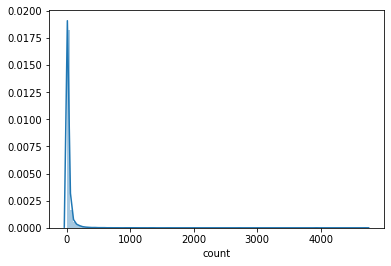

In [23]:
sns.distplot(newDf['count'],bins=100,norm_hist=True)

In [24]:
counts = list(newDf['count'])

In [30]:
np.percentile(newDf['count'],75)

30.0

In [8]:
# ==========================
# Append a hash to speed up processing
# ==========================
def get_hash_aux(row, id_col):
    row_dict = row.to_dict()
    del row_dict[id_col]
    _str = '_'.join([str(_) for _ in row_dict.values()])
    _str = str.encode(_str)
    str_hash = hashlib.md5(_str).hexdigest()
    return str_hash


def add_hash(df, id_col):
    df['hash'] = df.apply(
        get_hash_aux,
        axis=1,
        args=(id_col,)
    )
    return df


def is_duplicate(ref_df, hash_val):
    if len(ref_df.loc[ref_df['hash'] == hash_val]) > 0: return True
    return False

# modify the id_col
def aux_modify_id(value, suffix):
    return int(str(value) + str(suffix))

def find_pattern_count(domainEntity_dict, ref_df):
    global id_col
    query_str = []

    for _c, _i in domainEntity_dict.items():
        query_str.append(' ' + _c + ' == ' + str(_i))
    query_str = ' & '.join(query_str)
    res_query = ref_df.query(query_str)
    return len(res_query)

def get_coOccMatrix_dict(df, id_col):
    columns = list(df.columns)
    columns.remove(id_col)
    columns = list(sorted(columns))
    columnWise_coOccMatrix_dict = {}

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col_1 = columns[i]
            col_2 = columns[j]
            key = col_1 + '_+_' + col_2
            res = clean_up_test_data.create_coocc_matrix(df, col_1, col_2)
            columnWise_coOccMatrix_dict[key] = res
    return columnWise_coOccMatrix_dict

In [3]:
CONFIG = set_up_config()
dict_coOccMatrix = get_coOccMatrix_dict(train_df, id_col)

Col 1 & 2 AdminRegion CountryOfSale (492, 205) >> (492, 205)
Col 1 & 2 AdminRegion HSCode (492, 130) >> (492, 130)
Col 1 & 2 AdminRegion Province (492, 31) >> (492, 31)
Col 1 & 2 AdminRegion ShipmentDestination (492, 206) >> (492, 206)
Col 1 & 2 AdminRegion ShipperPanjivaID (492, 14088) >> (492, 14088)
Col 1 & 2 AdminRegion TradeType (492, 9) >> (492, 9)
Col 1 & 2 AdminRegion TransportMethod (492, 6) >> (492, 6)
Col 1 & 2 CountryOfSale HSCode (205, 130) >> (205, 130)
Col 1 & 2 CountryOfSale Province (205, 31) >> (205, 31)
Col 1 & 2 CountryOfSale ShipmentDestination (205, 206) >> (205, 206)
Col 1 & 2 CountryOfSale ShipperPanjivaID (205, 14088) >> (205, 14088)
Col 1 & 2 CountryOfSale TradeType (205, 9) >> (205, 9)
Col 1 & 2 CountryOfSale TransportMethod (205, 6) >> (205, 6)
Col 1 & 2 HSCode Province (130, 31) >> (130, 31)
Col 1 & 2 HSCode ShipmentDestination (130, 206) >> (130, 206)
Col 1 & 2 HSCode ShipperPanjivaID (130, 14088) >> (130, 14088)
Col 1 & 2 HSCode TradeType (130, 9) >> (130

In [17]:
def check_nonZeroCoOccurrence(
    dict_domain_entities, 
    dict_coOccMatrix
):
    domains = sorted(dict_domain_entities.keys())
    for d_pair in combinations(domains,2):
        d_pair = sorted(d_pair)
        key = '_+_'.join(d_pair)
        if dict_coOccMatrix[
            dict_domain_entities[d_pair[0]], 
            dict_domain_entities[d_pair[1]]
        ] == 0 : return False
    return True

In [34]:
    
def find_conflicting_patterns(train_df, dict_coOccMatrix, id_col, pattern_size = 4, count = 10):
        
    domains = list(sorted(train_df.columns))
    domains.remove(id_col)
    # create set of entity ids for each of the domains
    domain_entitiesSet_dict = {}
    min_pattern_count =  5
    for d in domains:
        domain_entitiesSet_dict[d] = list(set(train_df[d]))
        
    anomalies_df = pd.DataFrame(
        columns=list(train_df.columns)
    )
    max_count = count
    max_iterations = 1000
    cur_count = 0
    while cur_count < max_count :    
        iterations = 0
        print ( domains )
        while iterations < max_iterations:
            domain_set = random.choice(domains, size = pattern_size, replace = False)
            print ( domain_set )        
            excluded_domain = random.choice(domain_set, size=1)[0]
            pos_set = list(domain_set)
            pos_set.remove(excluded_domain)
            candidate_dict = {}
            
            _tries1 = 0 
            while True:
                for d in pos_set:
                    # sample entity
                    candidate_dict[d] = random.choice(domain_entitiesSet_dict[d], size=1)[0]
                if check_nonZeroCoOccurrence( candidate_dict, dict_coOccMatrix) == True: continue
                _tries1 += 1
            print(' Tries (1) :: ', _tries1)
            if find_pattern_count(candidate_dict, train_df) >= min_pattern_count:
                _tries2 = 0
                condition_satisfied = False
                while condition_satisfied == False:
                    cand_e = random.choice(domain_entitiesSet_dict[excluded_domain], size=1)[0]
                    candidate_dict[excluded_domain] = cand_e
                    # Ensure that cand_e has non-zero co-occurrence with others
                    for dpair in combinations(list(candidate_dict.keys()),2):
                        subSet_dict = {}
                        subSet_dict[dpair[0]] = candidate_dict[dpair[0]]
                        subSet_dict[dpair[1]] = candidate_dict[dpair[1]]
                        if check_nonZeroCoOccurrence( subSet_dict, dict_coOccMatrix) == False:
                            condition_satisfied = False
                            break
                        else:
                            condition_satisfied = True
                    
                    _tries2 += 1
                print(' Tries (2) :: ', _tries2)        
            iterations += 1
            
        cur_count += 1

In [35]:
find_conflicting_patterns(train_df, dict_coOccMatrix, id_col, pattern_size = 4, count = 10)

['AdminRegion', 'CountryOfSale', 'HSCode', 'Province', 'ShipmentDestination', 'ShipperPanjivaID', 'TradeType', 'TransportMethod']


TypeError: choice() got an unexpected keyword argument 'size'

In [31]:
a = ['AdminRegion', 'CountryOfSale', 'HSCode', 'Province', 'ShipmentDestination', 'ShipperPanjivaID', 'TradeType', 'TransportMethod']

np.random.choice(a,size=4,replace=False)

array(['CountryOfSale', 'TradeType', 'TransportMethod',
       'ShipperPanjivaID'], dtype='<U19')